# Bayesian Networks

**Colaborators:** Andrej Betík (456604), Robin Knaur (409844), Jiří Novotný (409963)

In [1]:
# Packages Installation 
install_pckgs_if_not_installed <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}
pckgs <- c("tidyr",
           "ggplot2",
           "caret",
           "corrplot",
           "gridExtra",
           "monomvn",
           "naivebayes",
           "ROSE",
           "bartMachine",
           "splitstackshape",
           "arm")
suppressWarnings(install_pckgs_if_not_installed(pckgs))

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: caret
Loading required package: lattice
Loading required package: corrplot
corrplot 0.84 loaded
Loading required package: gridExtra
Loading required package: monomvn
Loading required package: pls

Attaching package: ‘pls’

The following object is masked from ‘package:corrplot’:

    corrplot

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings

Loading required package: lars
Loaded lars 1.2

Loading required package: MASS
Loading required package: naivebayes
Loading required package: ROSE
Loaded ROSE 0.0-3

Loading required package: bartMachine
Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomFor

tidyr         ggplot2           caret        corrplot       gridExtra 
           TRUE            TRUE            TRUE            TRUE            TRUE 
        monomvn      naivebayes            ROSE     bartMachine splitstackshape 
           TRUE            TRUE            TRUE            TRUE            TRUE 
            arm 
           TRUE

## 1. Introduction

### We have chosen these three methods
 - Bayesian Generalized Linear Model (Robin Knaur)
 - Bayesian Additive Regression Trees (Andrej Betík)
 - Bayesian Ridge Regression (Jiří Novotný)
 
 ### And we have these three datasets
 - Bank dataset (Robin Knaur)
 - German Credit Data (Andrej Betík)
 - Energy efficiency (Jiří Novotný)
 

## 2. Exploratory Analysis

### Bank dataset
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

#### Attribute Information:

##### Input variables:
###### bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
###### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
###### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
###### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

###### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')




In [2]:
#load datasets
bank_train <- read.csv("datasets/bank-additional.csv", sep=";")
bank_test <- read.csv("datasets/bank-additional-full.csv", sep=";")

head(bank_train)

age,job,marital,education,default,housing,loan,contact,month,day_of_week,⋯,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,⋯,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
39,services,single,high.school,no,no,no,telephone,may,fri,⋯,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
25,services,married,high.school,no,yes,no,telephone,jun,wed,⋯,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,⋯,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,⋯,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
32,services,single,university.degree,no,no,no,cellular,sep,thu,⋯,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no


In [3]:
# number of samples
nrow(bank_train)
nrow(bank_test)

[1] 4119

[1] 41188

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

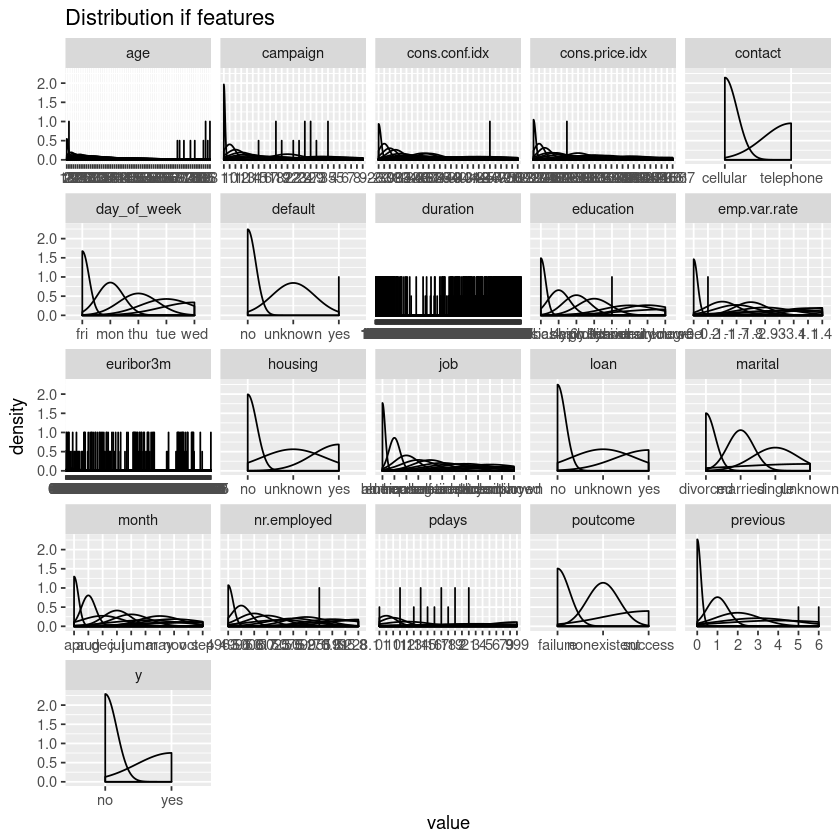

In [4]:
library(tidyr)
library(ggplot2)

# look at distribution of values for each feature
ggplot(gather(bank_train), aes(value)) +
    geom_density() +
    facet_wrap(~key, scales = 'free_x') +
    ggtitle("Distribution if features")

### German Credit Data
The original dataset contains 1000 entries with 20 categorial/symbolic attributes. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.
I have ignored some columns, because either they are not important or their descriptions are obscure. The original dataset can be found at https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

#### Attribute Information:
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
###### Output variable (desired target)
10. Risk (Value target - Good or Bad Risk)

### Visualization

In [4]:
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(gridExtra)))
german_credit <- read.csv("datasets/german_credit.csv")
str(german_credit)

'data.frame':	1000 obs. of  10 variables:
 $ Age             : int  67 22 49 45 53 35 53 35 61 28 ...
 $ Sex             : Factor w/ 2 levels "female","male": 2 1 2 2 2 2 2 2 2 2 ...
 $ Job             : int  2 2 1 2 2 1 2 3 1 3 ...
 $ Housing         : Factor w/ 3 levels "free","own","rent": 2 2 2 1 1 1 2 3 2 2 ...
 $ Saving.accounts : Factor w/ 4 levels "little","moderate",..: NA 1 1 1 1 NA 3 1 4 1 ...
 $ Checking.account: Factor w/ 3 levels "little","moderate",..: 1 2 NA 1 1 NA NA 2 NA 2 ...
 $ Credit.amount   : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ Duration        : int  6 48 12 42 24 36 24 36 12 30 ...
 $ Purpose         : Factor w/ 8 levels "business","car",..: 6 6 4 5 2 4 5 2 6 2 ...
 $ Risk            : Factor w/ 2 levels "bad","good": 2 1 2 2 1 2 2 2 2 1 ...


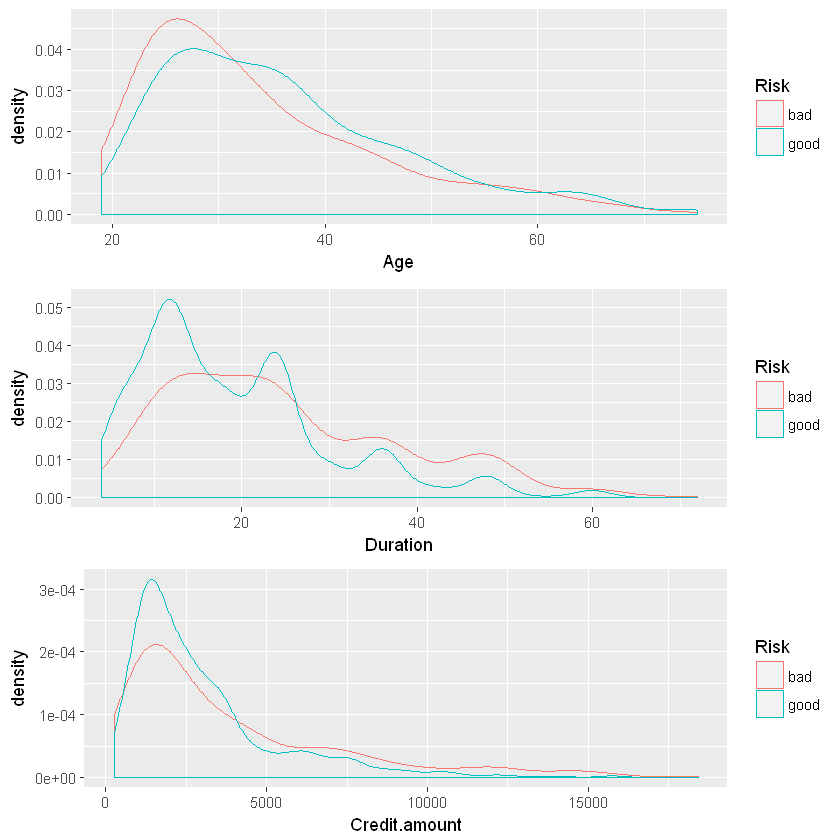

In [5]:
# Inspection of some interesting data features

# People at very young age seem to have worse credit worthiness
p1 <- ggplot(german_credit, aes(x=Age, color=Risk)) + geom_density()
# Surprisingly there's not really a trend of "Longer duration better credit worthiness"
p2 <- ggplot(german_credit, aes(x=Duration, color=Risk)) + geom_density()
# A trend of "Higher credit amount, better credit worthiness"
p3 <- ggplot(german_credit, aes(x=Credit.amount, color=Risk)) + geom_density()
grid.arrange(p1, p2, p3)

### Energy efficiency
* Authors: Angeliki Xifara, Athanasios Tsanas
* Link: https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

#### Abstract
Authors performed energy analysis using 12 different building shapes simulated in Ecotect. The buildings differed with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. They simulated various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

#### Attributes
* X1 Relative Compactness
* X2 Surface Area
* X3 Wall Area
* X4 Roof Area
* X5 Overall Height
* X6 Orientation
* X7 Glazing Area
* X8 Glazing Area Distribution
* y1 Heating Load
* y2 Cooling Load

In [6]:
#load csv
energy <- read.csv("datasets/energy_efficency.csv")

#rename columns
names(energy) <- c("relative_compactness", "surface_area", "wall_area", "roof_area", "overall_height",
                   "orientation", "glazing_area", "glazing_area_distribution", "heating_load", "cooling_load")
head(energy)

relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0.98,514.5,294.0,110.25,7,2,0,0,15.55,21.33
0.98,514.5,294.0,110.25,7,3,0,0,15.55,21.33
0.98,514.5,294.0,110.25,7,4,0,0,15.55,21.33
0.98,514.5,294.0,110.25,7,5,0,0,15.55,21.33
0.90,563.5,318.5,122.50,7,2,0,0,20.84,28.28
0.90,563.5,318.5,122.50,7,3,0,0,21.46,25.38


In [7]:
# number of samples
nrow(energy)

[1] 768

Warning message:
"package 'tidyr' was built under R version 3.3.3"

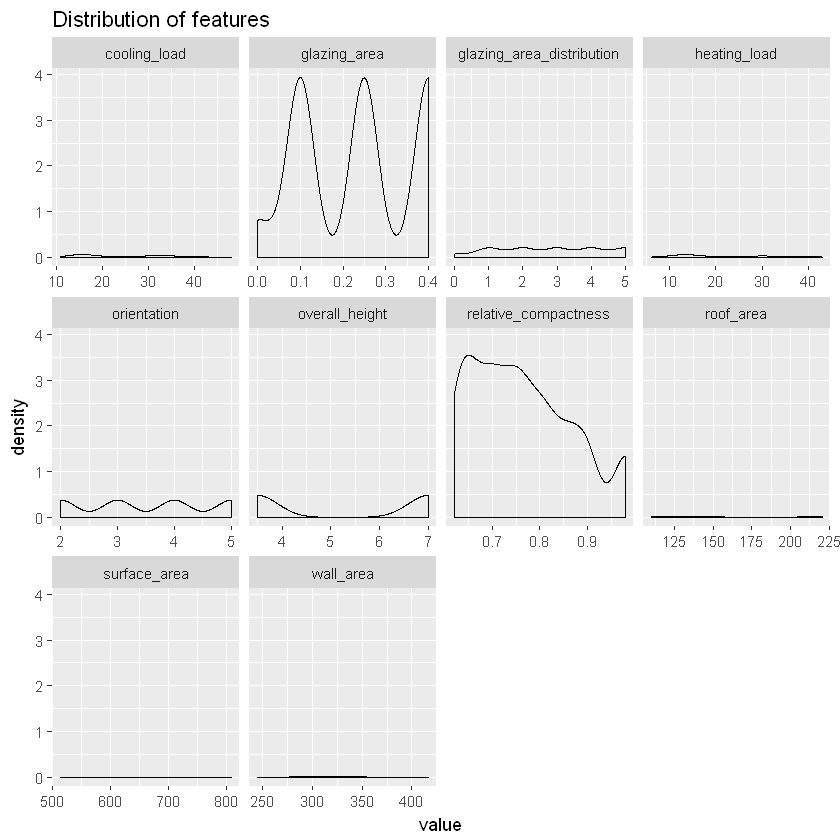

In [8]:
library(tidyr)
library(ggplot2)

# look at distribution of values for each feature
ggplot(gather(energy), aes(value)) +
    geom_density() +
    facet_wrap(~key, scales = 'free_x') +
    ggtitle("Distribution of features")

Warning message:
"package 'corrplot' was built under R version 3.3.3"corrplot 0.84 loaded


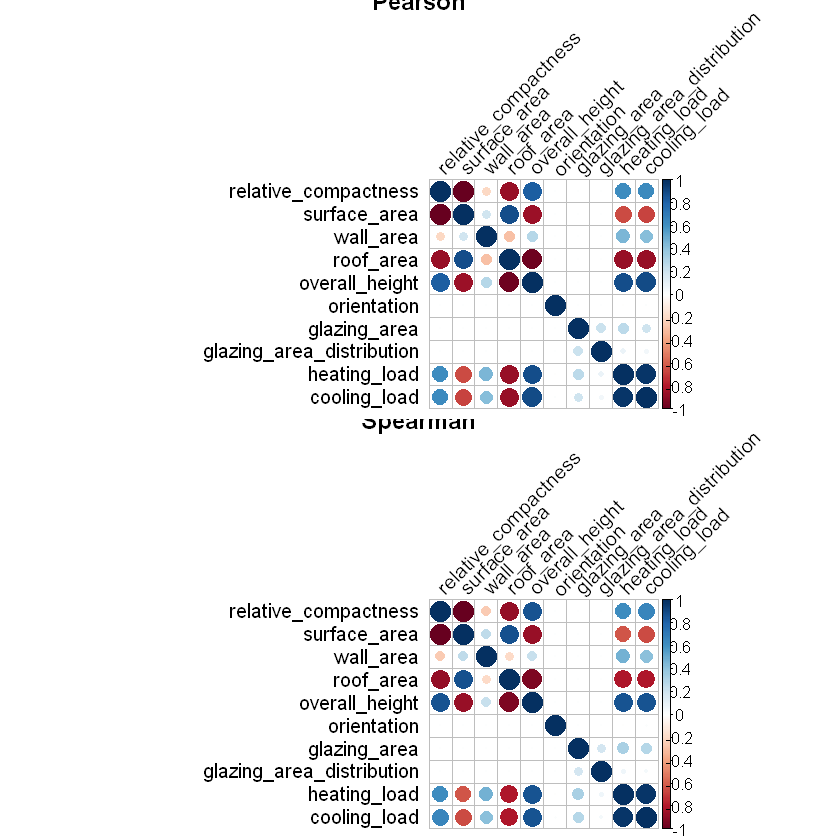

In [9]:
library(corrplot)

# show Pearson's and Spearman's coorelation plots (sorry for the badly placed titles)
layout(matrix(1:2, nrow=2, ncol=1))
corrplot::corrplot(cor(energy, method="pearson"), tl.col="black", tl.srt=45, title="Pearson")
corrplot::corrplot(cor(energy, method="spearman"), tl.col="black", tl.srt=45, title="Spearman")

From these two correlation matricies we can say, that the *orientation*, *glazing_area*, or *glazing_area_distribution* variables have little or no impact on the dependent variables (*heating_load* and *cooling_load*).
The *heating_load* and *cooling_load* shows strong correlations in between, this is completely fine, beacause they are our targert variables.

## 3. Preprocessing

### Bank dataset

This dataset could be used without any preprocessing, but it still be usefull to do some.

First remove the duration column, becase it represents length of a phone call which couldn't be known before phonecall itself and strongly correlate with output variable.

Since it's a telemarketing, majority of people refused an offer, so the distribution of classes is unbalanced. I decided to use oversampling to deal with this issue. If I wouldn't use it, sensitivity would be very low.


In [10]:
library('caret')
library('arm')

#remove duration column
bank_train_without_duration <- subset(bank_train, select = -c(duration))
bank_test_without_duration <- subset(bank_test, select = -c(duration))

# oversampling
library(splitstackshape)

yes_rows = subset(bank_train, y == 'yes')
multiplied_yes_rows = expandRows(yes_rows, 8, count.is.col = FALSE, drop = FALSE)
oversampled_bank_train = rbind(bank_train, multiplied_yes_rows)

Warning message:
"package 'arm' was built under R version 3.3.3"Loading required package: MASS
Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

Loading required package: lme4
Warning message:
"package 'lme4' was built under R version 3.3.3"
arm (Version 1.10-1, built: 2018-4-12)

Working directory is C:/Andrej/ib031_projekt/bayesian-networks


Attaching package: 'arm'

The following object is masked from 'package:corrplot':

    corrplot



ERROR: Error in subset(bank_train, select = -c(duration)): object 'bank_train' not found


### German Credit Data
#### Preprocessing consits of :
##### 1)  Handling of Missing Data
##### 2) Ballancing the data

In [11]:
# Checking for missing values
sum(is.na(german_credit))

[1] 577

In [12]:
# But all of them are in attributes Saving.accounts and Checking.accounts which are categorical values
sum(is.na(german_credit$Checking.account)) + sum(is.na(german_credit$Saving.accounts))

[1] 577

In [13]:
# To get rid of missing values I replace <NA> samples with a new level "Unknown"
levels(german_credit$Saving.accounts) = c(levels(german_credit$Saving.accounts), "Unknown")
german_credit$Saving.accounts[which(is.na(german_credit$Saving.accounts))] = "Unknown"
levels(german_credit$Checking.account) = c(levels(german_credit$Checking.account), "Unknown")
german_credit$Checking.account[which(is.na(german_credit$Checking.account))] = "Unknown"

In [14]:
any(is.na(german_credit))

[1] FALSE

In [15]:
# Apparantly this dataset is unballanced(has unequal instances for different classes)
table(german_credit$Risk)


 bad good 
 300  700 

In [16]:
# Using function ovun.sample to ballance the data
# It creates possibly balanced samples by combination of random over-sampling minority examples and under-sampling
# majority examples.
# Over/Under sampling whole dataset would create copies of the same point.
# It may end up in both the training and test sets. This allows the classifier to cheat.
# Firstly I will divide the dataset to train/test and over/under sample just the train one.
set.seed(123)
trainIndex <- createDataPartition(german_credit$Risk, .7, list=FALSE, times = 1)
german_credit_train <- german_credit[trainIndex,]
german_credit_test <- german_credit[-trainIndex,]

In [17]:
# Before the over/under sampling
table(german_credit_train$Risk)


 bad good 
 210  490 

In [18]:
suppressPackageStartupMessages(suppressWarnings(library(ROSE)))
german_credit_train <- ovun.sample(Risk~., data=german_credit_train,
                                   N=nrow(german_credit_train), p=0.5, 
                                   seed=1, method="both")$data
# After the over/under sampling
table(german_credit_train$Risk)


good  bad 
 360  340 

### Energy efficiency

In [20]:
# Contains any NA values?
any(is.na(energy))

[1] FALSE

In [21]:
# define my version of summary method with standard deviation included
energy_summary <- function(df) {
    data.frame(mean=sapply(df, mean),
               std=sapply(df, sd),
               min=sapply(df, min),
               q_0.25=sapply(df, function(col) quantile(col, probs=0.25)),
               q_0.50=sapply(df, function(col) quantile(col, probs=0.50)),
               q_0.75=sapply(df, function(col) quantile(col, probs=0.75)),
               max=sapply(df, max))
}

# check the means and standard deviations for each feature
energy_summary(energy)

,mean,std,min,q_0.25,q_0.50,q_0.75,max
relative_compactness,0.7641667,0.1057775,0.62,0.6825,0.75,0.8300,0.98
surface_area,671.7083333,88.0861161,514.50,606.3750,673.75,741.1250,808.50
wall_area,318.5000000,43.6264814,245.00,294.0000,318.50,343.0000,416.50
roof_area,176.6041667,45.1659502,110.25,140.8750,183.75,220.5000,220.50
overall_height,5.2500000,1.7511404,3.50,3.5000,5.25,7.0000,7.00
orientation,3.5000000,1.1187626,2.00,2.7500,3.50,4.2500,5.00
glazing_area,0.2343750,0.1332206,0.00,0.1000,0.25,0.4000,0.40
glazing_area_distribution,2.8125000,1.5509597,0.00,1.7500,3.00,4.0000,5.00
heating_load,22.3071953,10.0902040,6.01,12.9925,18.95,31.6675,43.10
cooling_load,24.5877604,9.5133056,10.90,15.6200,22.08,33.1325,48.03


In [22]:
# normalize each feature (transform them to have mean=0 and std=1) - leave out the dependant variables
energy_feat <- energy[, !(names(energy) %in% c("heating_load", "cooling_load"))]
energy_feat <- as.data.frame(scale(energy_feat))
energy_feat$heating_load <- energy$heating_load
energy_feat$cooling_load <- energy$cooling_load
energy <- energy_feat
rm(energy_feat)

# recheck the means and stadard deviations
energy_summary(energy)

,mean,std,min,q_0.25,q_0.50,q_0.75,max
relative_compactness,-7.914394e-18,1.000000,-1.3629241,-0.7720610,-0.13392895,0.6223757,2.0404470
surface_area,-4.431493e-16,1.000000,-1.7847118,-0.7416984,0.02317808,0.7880546,1.5529311
wall_area,0.000000e+00,1.000000,-1.6847565,-0.5615855,0.00000000,0.5615855,2.2463421
roof_area,2.036136e-16,1.000000,-1.4691192,-0.7910642,0.15821284,0.9718789,0.9718789
overall_height,0.000000e+00,1.000000,-0.9993487,-0.9993487,0.00000000,0.9993487,0.9993487
orientation,0.000000e+00,1.000000,-1.3407670,-0.6703835,0.00000000,0.6703835,1.3407670
glazing_area,1.158831e-16,1.000000,-1.7593005,-1.0086656,0.11728670,1.2432390,1.2432390
glazing_area_distribution,1.053257e-17,1.000000,-1.8133934,-0.6850597,0.12089289,0.7656550,1.4104171
heating_load,2.230720e+01,10.090204,6.0100000,12.9925000,18.95000000,31.6675000,43.1000000
cooling_load,2.458776e+01,9.513306,10.9000000,15.6200000,22.08000000,33.1325000,48.0300000


In [23]:
# Split the dataset into train and test subsets, use the 70-30 split.
# We will only do the prediction for heating load, since cooling_load is strongly
# correlated with heating_load and our picked models does not support multiple
# task-learning.

indicies <- createDataPartition(energy$heating_load, p=0.7, list=FALSE)
energy_train <- energy[indicies,]
energy_test <- energy[-indicies,]

In [24]:
nrow(energy_train)
nrow(energy_test)

[1] 540

[1] 228

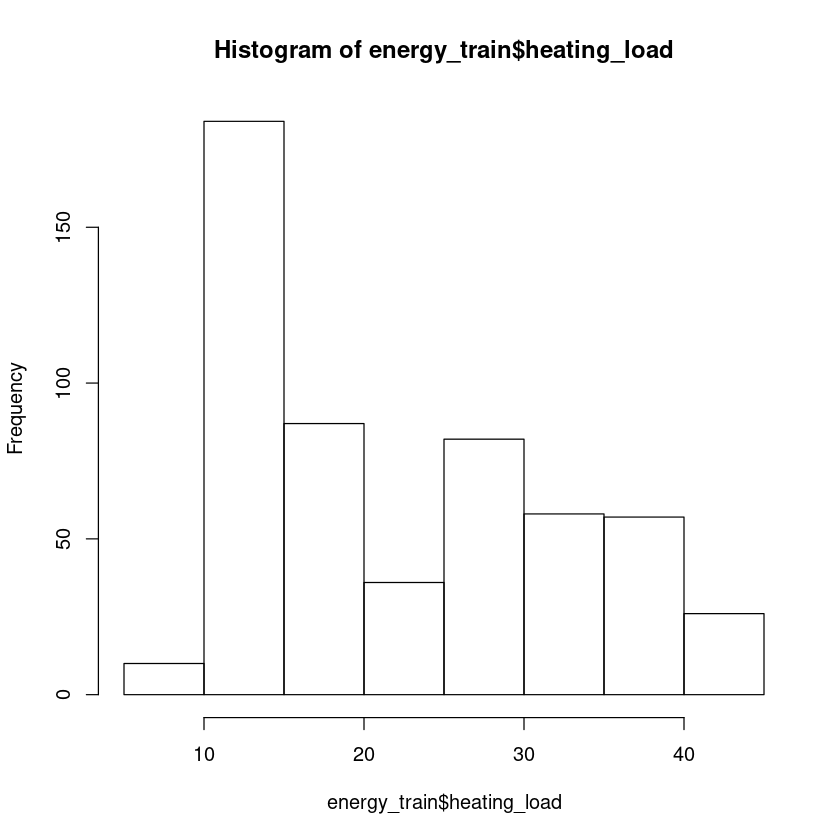

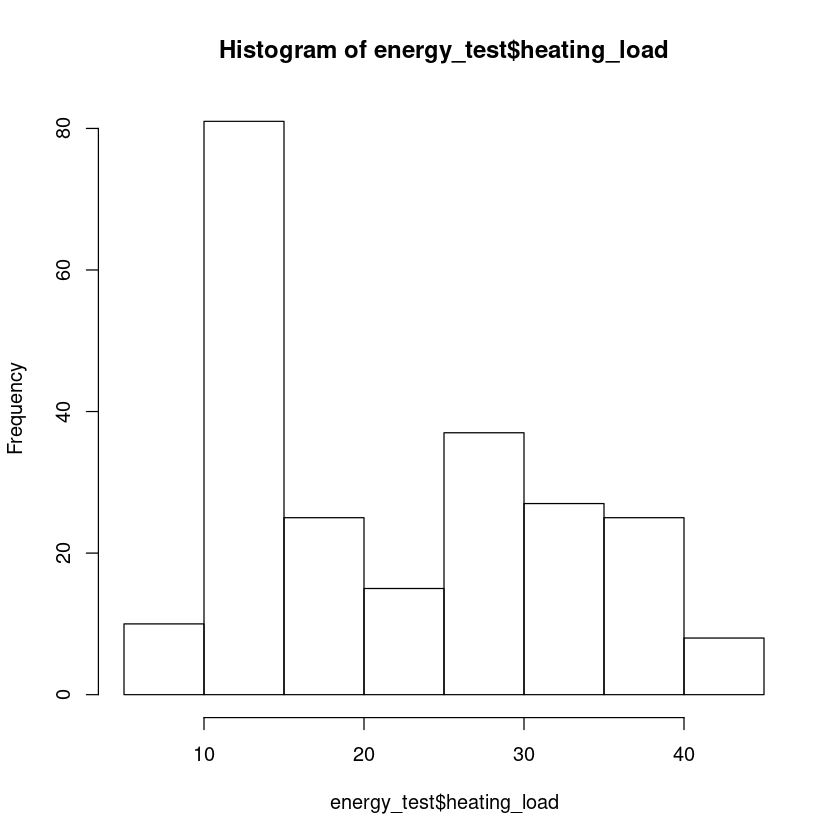

In [25]:
# check the distribution of heating_load in all subsests (did we split it right?)
# we should see the same distribution in all subsets

hist(energy_train$heating_load)
hist(energy_test$heating_load)

## 4. Learning Algorithms

### Bayesian Generalized Linear Model

Generalized Linear Model is defined by assuming that y1, y2,...yn are independent observations, where yi has the density from the natural exponential family.
    f(yi|θi) = exp{(θiyi−ψ(θi)) +c(yi)},

The GLM consists of three elements:

    1. A probability distribution from the exponential family.
    2. A linear predictor η = Xβ .
    3. A link function g such that E(Y) = μ = g−1(η).
1.
The overdispersed exponential family of distributions is a generalization of the exponential family and exponential dispersion model of distributions and includes those probability distributions, parameterized by θ and τ, whose density functions f (or probability mass function, for the case of a discrete distribution) can be expressed in the form
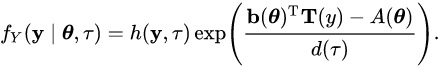


τ , called the dispersion parameter, typically is known and is usually related to the variance of the distribution. The functions h (y, τ), T (y),  b(y), A(θ), and d (τ) are known. Many common distributions are in this family, including the normal, exponential, gamma, Poisson, Bernoulli, and (for fixed number of trials) binomial, multinomial, and negative binomial.


2.
The linear predictor is the quantity which incorporates the information about the independent variables into the model. The symbol η denotes a linear predictor. It is related to the expected value of the data (thus, "predictor") through the link function.

η is expressed as linear combinations (thus, "linear") of unknown parameters β. The coefficients of the linear combination are represented as the matrix of independent variables X. η can thus be expressed as
η = Xβ

3.
The link function provides the relationship between the linear predictor and the mean of the distribution function. There are many commonly used link functions, and their choice is informed by several considerations. There is always a well-defined canonical link function which is derived from the exponential of the response's density function. However, in some cases it makes sense to try to match the domain of the link function to the range of the distribution function's mean, or use a non-canonical link function for algorithmic purposes, for example Bayesian probit regression.

#### Bayesian Methods
In general, the posterior distribution cannot be found in closed form and so must be approximated, usually using Laplace approximations or some type of Markov chain Monte Carlo method such as Gibbs sampling.

### Bayesian Additive Regression Trees

BART is a nonparametric Bayesian regression approach which
uses dimensionally adaptive random basis elements. Motivated by ensemble methods in
general, and boosting algorithms in particular, BART is defined by a statistical model:
a prior and a likelihood. This approach enables full posterior inference including point
and interval estimates of the unknown regression function as well as the marginal effects
of potential predictors. By keeping track of predictor inclusion frequencies, BART can
also be used for model free variable selection. BART’s many features are illustrated
with a bake-off against competing methods on 42 different data sets, with a simulation
experiment and on a drug discovery classification problem.

#### German Credit Data

In [26]:
# Setting computing parameters for BartMachine. 4 GB RAM for Java heap and number of computing cores set to 4.
suppressPackageStartupMessages(suppressWarnings(options(java.parameters = "-Xmx4g")))
suppressPackageStartupMessages(suppressWarnings(set_bart_machine_num_cores(4)))

bartMachine now using 4 cores.


In [ ]:
bartTrainControl <- trainControl(method = "cv",  number=3, verboseIter=FALSE)
bartmachine_fit <- suppressWarnings(train(Risk ~ ., 
                                          data = german_credit_train, 
                                          method ="bartMachine",
                                          trControl = bartTrainControl,
                                          metric = 'Accuracy',
                                          verbose = FALSE))

In [3]:
bartMachine_predict <- predict(bartmachine_fit, german_credit_test, verbose = FALSE)

ERROR: Error in predict(bartmachine_fit, german_credit_test, verbose = FALSE): object 'bartmachine_fit' not found


In [ ]:
# These two dataset took extremly long time to train.
# More info in evaluation part.

#### Bank Data

In [ ]:
# Reduced num trees so it takes less time to Train
gbmGrid <-  expand.grid(num_trees = 15, alpha = 0.05, beta = 0.95, nu = 3) 
bart_machine_bank_model <- train(y ~ ., data = oversampled_bank_train, method = 'bartMachine')

#### Energy efficiency

In [ ]:
# Reduced num trees so it takes less time to Train
gbmGrid <-  expand.grid(num_trees = 15, alpha = 0.05, beta = 0.95, nu = 3) 
bart_machine_energy_model <- train(heating_load ~ .,
                                 data=energy_train,
                                 method="bartMachine")

### Bayesian Ridge Regression

The Bayesian Linear regression is basicaly a linear regression with added regulatization parameter which is implied "from the data". The Bayesian ridge regression is a specialized form of a Bayesian linerar regression.

The inputs are of the form of $\{(x_i, y_i), ..., (x_n, y_n)\}$, where $x_i \in \mathbb{R}^d$, $y_i \in \mathbb{R}$ for some $d$.

The ouptuts $Y_i, ..., Y_n$ are from a Gaussian $Y_{i} \sim \mathcal{N}(w^{T}x_{i}, \alpha^{-1})$.

For a Ridge Regression the parameter $w$ is given by a multivariate gausian:
$w \sim \mathcal{N}(0, \lambda^{-1} I_p)$ where $w = (w_1, ..., w_d)$. The parameters $w$, $\alpha$ and $\lambda$ are estimated from the data (I dont know how :D). 

The benifits of Bayesian regression are adaptation to the data and a possible inclusion of regulatization parameters (which a Ridge regression has).

There are very little online sources to understand the Bayesian regression, so the description as my undesteding of the algorithm are limited.


Sources:
* https://www.youtube.com/watch?v=1WvnpjljKXA
* http://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression
* http://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0120017.s001
* https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7

## 5. Evaluation


### Bayesian Generalized Linear Model

#### Bank dataset

In [29]:
bglm_bank_model <- train(y ~ ., data = oversampled_bank_train, method = 'bayesglm')

bglm_bank_prediction <- predict(bglm_bank_model, newdata = bank_test)
confusionMatrix(bglm_bank_prediction, bank_test$y, positive="yes")

Confusion Matrix and Statistics

          Reference
Prediction    no   yes
       no  31502   574
       yes  5046  4066
                                          
               Accuracy : 0.8636          
                 95% CI : (0.8602, 0.8669)
    No Information Rate : 0.8873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.5196          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.87629         
            Specificity : 0.86193         
         Pos Pred Value : 0.44622         
         Neg Pred Value : 0.98211         
             Prevalence : 0.11265         
         Detection Rate : 0.09872         
   Detection Prevalence : 0.22123         
      Balanced Accuracy : 0.86911         
                                          
       'Positive' Class : yes             
                                          

#### German credit Data

In [30]:
bglm_credit_model <- train(Risk ~ ., data = german_credit[trainIndex,], method = 'bayesglm')


bglm_credit_prediction <- predict(bglm_credit_model, german_credit[-trainIndex,])
confusionMatrix(bglm_credit_prediction, german_credit_test$Risk)

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad   38   45
      good  52  165
                                          
               Accuracy : 0.6767          
                 95% CI : (0.6205, 0.7293)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.8279          
                                          
                  Kappa : 0.2127          
 Mcnemar's Test P-Value : 0.5424          
                                          
            Sensitivity : 0.4222          
            Specificity : 0.7857          
         Pos Pred Value : 0.4578          
         Neg Pred Value : 0.7604          
             Prevalence : 0.3000          
         Detection Rate : 0.1267          
   Detection Prevalence : 0.2767          
      Balanced Accuracy : 0.6040          
                                          
       'Positive' Class : bad             
                                          

#### Energy efficiency

In [41]:
blgm_energy_fit <- train(heating_load ~ .,
                           data=energy_train,
                           method="bridge",
                           metric="Rsquared")

blgm_energy_pre <- predict(blgm_energy_fit,
                             energy_test)
caret::R2(blgm_energy_pre, energy_test$heating_load)

t=100, m=6
t=200, m=5
t=300, m=7
t=400, m=5
t=500, m=5
t=600, m=6
t=700, m=5
t=800, m=6
t=900, m=5
t=100, m=6
t=200, m=4
t=300, m=6
t=400, m=5
t=500, m=5
t=600, m=4
t=700, m=7
t=800, m=4
t=900, m=5
t=100, m=5
t=200, m=7
t=300, m=5
t=400, m=4
t=500, m=7
t=600, m=4
t=700, m=5
t=800, m=6
t=900, m=4
t=100, m=5
t=200, m=7
t=300, m=6
t=400, m=7
t=500, m=7
t=600, m=6
t=700, m=6
t=800, m=6
t=900, m=6
t=100, m=7
t=200, m=6
t=300, m=4
t=400, m=6
t=500, m=5
t=600, m=5
t=700, m=7
t=800, m=7
t=900, m=5
t=100, m=6
t=200, m=6
t=300, m=8
t=400, m=5
t=500, m=5
t=600, m=5
t=700, m=6
t=800, m=7
t=900, m=6
t=100, m=6
t=200, m=5
t=300, m=6
t=400, m=5
t=500, m=7
t=600, m=5
t=700, m=5
t=800, m=6
t=900, m=5
t=100, m=6
t=200, m=8
t=300, m=5
t=400, m=5
t=500, m=8
t=600, m=7
t=700, m=4
t=800, m=5
t=900, m=5
t=100, m=6
t=200, m=6
t=300, m=5
t=400, m=6
t=500, m=6
t=600, m=7
t=700, m=7
t=800, m=7
t=900, m=7
t=100, m=6
t=200, m=5
t=300, m=6
t=400, m=6
t=500, m=5
t=600, m=5
t=700, m=7
t=800, m=7
t=900, m=6
t=100, m=5

[1] 0.9745888

### Bayesian Ridge Regression

#### Energy efficiency

In [32]:
bridge_energy_fit <- train(heating_load ~ .,
                           data=energy_train,
                           method="bridge",
                           metric="Rsquared")

bridge_energy_pre <- predict(bridge_energy_fit,
                             energy_test)

t=100, m=6
t=200, m=6
t=300, m=6
t=400, m=7
t=500, m=6
t=600, m=6
t=700, m=6
t=800, m=6
t=900, m=7
t=100, m=5
t=200, m=5
t=300, m=6
t=400, m=6
t=500, m=6
t=600, m=4
t=700, m=6
t=800, m=6
t=900, m=6
t=100, m=5
t=200, m=5
t=300, m=5
t=400, m=5
t=500, m=7
t=600, m=4
t=700, m=5
t=800, m=6
t=900, m=6
t=100, m=5
t=200, m=5
t=300, m=5
t=400, m=6
t=500, m=5
t=600, m=5
t=700, m=5
t=800, m=6
t=900, m=6
t=100, m=5
t=200, m=6
t=300, m=6
t=400, m=6
t=500, m=7
t=600, m=6
t=700, m=7
t=800, m=6
t=900, m=6
t=100, m=7
t=200, m=5
t=300, m=7
t=400, m=5
t=500, m=7
t=600, m=6
t=700, m=6
t=800, m=5
t=900, m=5
t=100, m=5
t=200, m=6
t=300, m=4
t=400, m=4
t=500, m=5
t=600, m=6
t=700, m=6
t=800, m=4
t=900, m=6
t=100, m=6
t=200, m=6
t=300, m=6
t=400, m=6
t=500, m=5
t=600, m=5
t=700, m=6
t=800, m=6
t=900, m=7
t=100, m=6
t=200, m=5
t=300, m=5
t=400, m=5
t=500, m=5
t=600, m=6
t=700, m=7
t=800, m=5
t=900, m=5
t=100, m=6
t=200, m=5
t=300, m=6
t=400, m=7
t=500, m=6
t=600, m=8
t=700, m=5
t=800, m=5
t=900, m=6
t=100, m=4

In [33]:
# The resulting R2 score for Bayesian Ridge Regression and Energy efficiency dataset.
# The R2 score means that such percentage of a variance can be explained by the model.

caret::R2(bridge_energy_pre, energy_test$heating_load)

[1] 0.9745506

#### German credit data

In [34]:
# Bacause the Ridge regression is only for a regression tasks and German credit data
# is a classification dataset, I will use a simple naive bayes.

naive_credit_fit <- train(Risk ~ .,
                        data=german_credit_train,
                        method="naive_bayes")

naive_credit_pre <- predict(naive_credit_fit, german_credit_test)

confusionMatrix(naive_credit_pre, german_credit_test$Risk)

Warning message in confusionMatrix.default(naive_credit_pre, german_credit_test$Risk):
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad   50   76
      good  40  134
                                          
               Accuracy : 0.6133          
                 95% CI : (0.5557, 0.6687)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.999457        
                                          
                  Kappa : 0.1738          
 Mcnemar's Test P-Value : 0.001155        
                                          
            Sensitivity : 0.5556          
            Specificity : 0.6381          
         Pos Pred Value : 0.3968          
         Neg Pred Value : 0.7701          
             Prevalence : 0.3000          
         Detection Rate : 0.1667          
   Detection Prevalence : 0.4200          
      Balanced Accuracy : 0.5968          
                                          
       'Positive' Class : bad             
                                          

#### Bank dataset

In [35]:
# Bacause the Ridge regression is only for a regression tasks and Bank dataset
# is a classification dataset, I will use a simple naive bayes.

naive_bank_fit <- train(y ~ .,
                        data=oversampled_bank_train,
                        method="naive_bayes")

naive_bank_pre <- predict(naive_bank_fit, bank_test)

confusionMatrix(naive_bank_pre, bank_test$y, positive="yes")

Confusion Matrix and Statistics

          Reference
Prediction    no   yes
       no  29071  1226
       yes  7477  3414
                                          
               Accuracy : 0.7887          
                 95% CI : (0.7847, 0.7926)
    No Information Rate : 0.8873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3345          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.73578         
            Specificity : 0.79542         
         Pos Pred Value : 0.31347         
         Neg Pred Value : 0.95953         
             Prevalence : 0.11265         
         Detection Rate : 0.08289         
   Detection Prevalence : 0.26442         
      Balanced Accuracy : 0.76560         
                                          
       'Positive' Class : yes             
                                          

### Bayesian Additive Regression Trees

#### German Credit Data

In [ ]:
confusionMatrix(bartMachine_predict, german_credit_test$Risk)

#### Bank Data


In [ ]:
#### Energy efficiency


## 6. Conclusion

### Bayesian Generalized Linear Model
This method doesn't is very sensitive to balanced distribution of classes and does not require scaling and/or scaling feature values. Also could be used for data with not normal distribution.

It has overal Accuracy 0.8636, 0.6767, 0.9745

### Bayesian Ridge Regression

The Bayesian Ridge regression has it's roots in linear models and bayesian statistics.
Because of that, the method is suitable for small datasets, as linear models are, but it may even perform better due to the regularization implied by the bayesian model.
The main disadvantage of this method is a relatively slow inference, thus it is not very suitable for large datasets.

I have chosen the Energy efficiency dataset. The Bayesian Ridge regresion achieved an $R^2$ score of $0.974$, which means that $97.4 \%$ of variations in dependent variable are explained by the independent variables in our model. The search on the internet revealed, that on this dataset the decision trees scores from $0.97$ to $0.98$.

Because of the other datasets are a classification datasets a must have chosen a different method to "benchmark" them. I have chosen the most simpliest baseline in Byesian networks, the naive bayes method.

In Bank dataset the naive bayes achieved $0.78$ accuracy, which is less then with Bayesian Generalized Linear Model. And in the Credit card dataset it also undermed other methods.

## 7. References

* https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
* https://en.wikipedia.org/wiki/Generalized_linear_model
* https://www.samsi.info/wp-content/uploads/2010/08/tr2007-08.pdf
* https://archive.ics.uci.edu/ml/datasets/Energy+efficiency
* https://www.youtube.com/watch?v=1WvnpjljKXA
* http://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression
* http://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0120017.s001
* https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7
